In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [3]:
x= np.array([1,2])
x = torch.from_numpy(x)
x = x.cuda()
print(x)

tensor([1, 2], device='cuda:0')


In [4]:
#分别得到坐标值和feature
#print(set(data['Yaw_Angle'].values),len(data['Yaw_Angle'].values))
data = pd.read_csv('处理数据/标准化数据.csv')
position_global = np.array(data[['Global_X','Global_Y']])
position_local =  np.array(data[['Local_X','Local_Y']])
#vehicle_feature = np.array(data.drop(['Vehicle_ID','Frame_ID','Total_Frames','Global_Time','Global_X','Global_Y','Location_peachtree'],
        #                            axis=1))
vehicle_feature = np.array(data[['Local_X','Local_Y',
                                 'v_length','v_Width','v_Class_1','v_Class_2',
                                 'v_Class_3','v_Vel','v_Acc','Preceding','Following',
                                 'Direction_1',
                                 'Direction_2','Direction_3','Direction_4','Movement_1','Movement_2','Movement_3',"Yaw_Angle"
                              ]])

vehicle_label = np.zeros_like(position_local)
vehicle_label[:-1],vehicle_label[-1] = position_local[1:],position_local[0]
#vehicle_label = position_local
vehicle_feature = vehicle_feature.astype(np.float32)
vehicle_label = vehicle_label.astype(np.float32)

split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)
train_x,val_test_x = vehicle_feature[:int(len(vehicle_feature)*split_frac)],vehicle_feature[int(len(vehicle_feature)*split_frac):]
val_x,test_x = val_test_x[:len(val_test_x)//2],val_test_x[len(val_test_x)//2:]

train_y,val_test_y = vehicle_label[:int(len(vehicle_label)*split_frac)],vehicle_label[int(len(vehicle_label)*split_frac):]
val_y,test_y = val_test_y[:len(val_test_y)//2],val_test_y[len(val_test_y)//2:]


import torch
from torch.utils.data import TensorDataset, DataLoader
 
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


# dataloaders
batch_size = 512

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

#iters = iter(train_loader)
#x, y = next(iters)
#print(x,y)
#得到车辆数
vehicle_id = np.array(data['Vehicle_ID'])
print('总采样数为:',len(vehicle_feature))
print('总车辆数为:',len(np.unique(vehicle_id)))



总采样数为: 1676606
总车辆数为: 1545


In [6]:
data1 = pd.read_csv('data/NGSIM_Peachtree_Vehicle_Trajectories.csv')
#data2 = pd.read_csv('data/NGSIM__Lankershim_Vehicle_Trajectories.csv')
data3  = pd.read_csv('data/Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data.csv')

data_ = pd.concat([data1,data3],axis=0)
quant_features = ['Local_X','Local_Y','Global_X','Global_Y']
scaled_features = {}
print('start..')

for each in quant_features:
    mean, std = data_[each].mean(), data_[each].max()-data_[each].min()
    scaled_features[each] = [mean, std]
    data_.loc[:, each] = (data_[each] - mean)/std
mean_x, std_x = scaled_features['Local_X']
mean_y, std_y = scaled_features['Local_Y']
print(mean_x, std_x)
print(mean_y, std_y)

start..
0.2436986727949202 486.509
927.7015568869493 2113.03


In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(LSTM, self).__init__()
        
        self.hidden_dim=hidden_dim
        self.n_layers = n_layers
        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers,dropout=0, batch_first=True)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim,hidden_dim*2)
        self.fc = nn.Linear(hidden_dim*2, output_size)
      
    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.lstm(x, hidden)
        """
        r_out = torch.mean(r_out,dim=2).squeeze()
        
        output= self.fc2(r_out)
         """
       # print(r_out.shape)#(512,1,512)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.contiguous().view(-1, self.hidden_dim)  
       # print(r_out.shape)(512,512)
        # get final output 
        output = self.fc1(r_out)
        output = self.fc(output)
        output = output.view(batch_size,-1,2)
      # print(output.shape)
        output = output[:,-1]
       # print(output.shape)
        
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if train_on_gpu:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

if torch.cuda.is_available():
    train_on_gpu = True
else:
    train_on_gpu = False

In [8]:
def train(net,epochs,train_loader,valid_loader,clip,print_every,lr = 0.0002):
    # train for some number of epochs
    # loss and optimization functions

    loss_min = np.inf
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    counter = 0
    losses_train =[]
    losses_val = []
    for e in range(epochs):
        # initialize hidden state
        # batch loop
        train_loss = []
        for inputs, labels in train_loader:
            h = net.init_hidden(inputs.shape[0])
            counter += 1
            h = tuple([each.data for each in h])
            inputs = inputs.unsqueeze(2)
            if (train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            # zero accumulated gradients
            net.zero_grad()
            # get the output from the model
            output, h = net(inputs, h)

            # calculate the loss and perform backprop
          #  print(output.shape,labels.shape)
            loss = criterion(output, labels)
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()
            train_loss.append(loss.item())
            # loss stats
            if counter % print_every == 0:
                # Get validation loss

                val_losses = []
                net.eval()
                accuracy = []
                for inputs, labels in valid_loader:
                    val_h = net.init_hidden(inputs.shape[0])
                    inputs = inputs.unsqueeze(2)
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                   # val_h = tuple([each.data for each in val_h])
                    val_h = tuple([each.data for each in val_h])
                    if (train_on_gpu):
                        inputs, labels = inputs.cuda(), labels.cuda()
                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, labels)
                    val_losses.append(val_loss.item())
                net.train()
                print("Epoch: {}/{}...".format(e + 1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {}...".format(np.mean(train_loss)),
                      "Val Loss: {}...".format(np.mean(val_losses)),
                     )
                losses_train.append(np.mean(train_loss))
                losses_val.append(np.mean(val_losses))
                if np.mean(train_loss) < loss_min:
                    print('Val loss decreased...')
                    torch.save(net.state_dict(),'model/lstm_trajectory_prediction_old.pt')
                    loss_min = np.mean(train_loss)
    print('min loss:',loss_min)
    plt.plot(losses_train,color='r',label='train_loss')
    plt.plot(losses_val,color='g',label='valid_loss')
    plt.title('Loss_Trend')
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    #plt.title('损失变化')
    #plt.xlabel('迭代次数')
    #plt.ylabel('损失大小')
    plt.legend()
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.savefig('trajectory_image/loss_lstm_trajectory_old.svg',dpi=300)
    plt.savefig('trajectory_image/loss_lstm_trajectory_old.png',dpi=300)

In [9]:
def test(net,test_loader):
    # Get test data loss and accuracy
    lr = 0.001

    criterion = nn.MSELoss()
    test_losses = []  # track loss
    num_correct = 0

    # init hidden stat

    net.eval()
    # iterate over test data
    for inputs, labels in test_loader:
        h = net.init_hidden(inputs.shape[0])
        inputs = inputs.unsqueeze(2)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        if (train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        # get predicted outputs
        output, h = net(inputs, h)

        # calculate loss
        test_loss = criterion(output, labels)
        test_losses.append(test_loss.item())


    print("Test loss: {:.3f}".format(np.mean(test_losses)))


In [13]:
def predict(net, test_loader):
    valid_loss = []
    criterion = nn.MSELoss()
    actual_angles,predict_angles = [],[]
    for i_, (x, y) in enumerate(test_loader):
        h = net.init_hidden(x.shape[0])
        x = x.unsqueeze(2)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        if i_ == 20:
            break
        if train_on_gpu:
            x, y = x.cuda(), y.cuda()
        out,h = net(x,h)

        loss = criterion(out, y)
        valid_loss.append(loss.item())
        y = y.cpu().detach().numpy().tolist()
        out = out.cpu().detach().numpy().tolist()
        print('Test Loss:', np.mean(valid_loss))
        actual_angle,predict_angle = [],[]
        actual_length = y[:30]
        predict_length = out[:30]
        for i in range(len(actual_length)-1):
            actual_angle.append(math.atan2((actual_length[i+1][1]*std_y + mean_y)-(actual_length[i][1]*std_y + mean_y),
                                           (actual_length[i+1][0]*std_x + mean_x) -(actual_length[i][0]*std_x + mean_x)))
            actual_angles.append(math.atan2((actual_length[i+1][1]*std_y + mean_y)-(actual_length[i][1]*std_y + mean_y),
                                           (actual_length[i+1][0]*std_x + mean_x) -(actual_length[i][0]*std_x + mean_x)))
        for i in range(len(predict_length)-1):
            predict_angle.append(math.atan2((predict_length[i+1][1]*std_y + mean_y)-(predict_length[i][1]*std_y + mean_y),
                                           (predict_length[i+1][0]*std_x + mean_x)-(predict_length[i][0]*std_x + mean_x)))
            predict_angles.append(math.atan2((predict_length[i+1][1]*std_y + mean_y)-(predict_length[i][1]*std_y + mean_y),
                                           (predict_length[i+1][0]*std_x + mean_x)-(predict_length[i][0]*std_x + mean_x)))
        for i in range(len(actual_angle)):
            print("actuale_angle_{}:{},prdict_angle_{}:{}".format(i,actual_angle[i],i,predict_angle[i]))
        plt.scatter([s[0] * std_x + mean_x for s in y[:30]],[s[1] * std_y + mean_y for s in y[:30]], color='r',
                    label='actual_trajectory')
        plt.scatter([s[0] * std_x + mean_x for s in out[:30]], [s[1] * std_y + mean_y for s in out[:30]], color='b',
                    label='predict_trajectory')
        plt.legend()
        plt.title('Trajectory')
        plt.savefig('trajectory_image/trajectory/trajectory_old/png/trajectory_old_{}.png'.format(i_),dpi=300)
        plt.savefig('trajectory_image/trajectory/trajectory_old/svg/trajectory_old_{}.svg'.format(i_),dpi=300)
        plt.show()
    return actual_angles,predict_angles

Epoch: 1/30... Step: 100... Loss: 0.05930608647176996... Val Loss: 0.005682237266006357...
Val loss decreased...
Epoch: 1/30... Step: 200... Loss: 0.05302931482205167... Val Loss: 0.006648813417463892...
Val loss decreased...
Epoch: 1/30... Step: 300... Loss: 0.051795005085878074... Val Loss: 0.009933420687114605...
Val loss decreased...
Epoch: 1/30... Step: 400... Loss: 0.05177776377357077... Val Loss: 0.013854546533477289...
Val loss decreased...
Epoch: 1/30... Step: 500... Loss: 0.05181521458551288... Val Loss: 0.009791561249762819...
Epoch: 1/30... Step: 600... Loss: 0.05183697898561756... Val Loss: 0.01314364098155837...
Epoch: 1/30... Step: 700... Loss: 0.05072864727482998... Val Loss: 0.012686392586967885...
Val loss decreased...
Epoch: 1/30... Step: 800... Loss: 0.05092028628903791... Val Loss: 0.012852276342838616...
Epoch: 1/30... Step: 900... Loss: 0.049851997958418603... Val Loss: 0.011801471683500538...
Val loss decreased...
Epoch: 1/30... Step: 1000... Loss: 0.04946668884

Epoch: 4/30... Step: 8400... Loss: 0.01095053687169167... Val Loss: 0.004474562305315375...
Val loss decreased...
Epoch: 4/30... Step: 8500... Loss: 0.009903725153105825... Val Loss: 0.005959174351230059...
Val loss decreased...
Epoch: 4/30... Step: 8600... Loss: 0.009115193928782656... Val Loss: 0.004495474160293958...
Val loss decreased...
Epoch: 4/30... Step: 8700... Loss: 0.010407463012996318... Val Loss: 0.004392018691117012...
Epoch: 4/30... Step: 8800... Loss: 0.010145511575250024... Val Loss: 0.0035226997861173004...
Epoch: 4/30... Step: 8900... Loss: 0.00964221540611666... Val Loss: 0.003203758574516808...
Epoch: 4/30... Step: 9000... Loss: 0.009018233590008126... Val Loss: 0.004515581710687157...
Val loss decreased...
Epoch: 4/30... Step: 9100... Loss: 0.008448159220264526... Val Loss: 0.004618181935767076...
Val loss decreased...
Epoch: 4/30... Step: 9200... Loss: 0.007939589963315308... Val Loss: 0.0037272933321485366...
Val loss decreased...
Epoch: 4/30... Step: 9300... Lo

Epoch: 7/30... Step: 16300... Loss: 0.0031633281686606943... Val Loss: 0.0022690664329452484...
Epoch: 7/30... Step: 16400... Loss: 0.002929099602140602... Val Loss: 0.002432673082760785...
Epoch: 7/30... Step: 16500... Loss: 0.0029047091919752487... Val Loss: 0.0029087061574966534...
Epoch: 7/30... Step: 16600... Loss: 0.0032686430817420844... Val Loss: 0.0021724921697147317...
Epoch: 7/30... Step: 16700... Loss: 0.003239246404305328... Val Loss: 0.0023435151421680772...
Epoch: 7/30... Step: 16800... Loss: 0.0030993501209347113... Val Loss: 0.002163460372419028...
Epoch: 7/30... Step: 16900... Loss: 0.002953269370033722... Val Loss: 0.001931580521447425...
Epoch: 7/30... Step: 17000... Loss: 0.002826684087566633... Val Loss: 0.0021216993687941305...
Epoch: 7/30... Step: 17100... Loss: 0.0027039209432554133... Val Loss: 0.0019126521851498316...
Epoch: 7/30... Step: 17200... Loss: 0.0025875671598693797... Val Loss: 0.002051069552491266...
Epoch: 7/30... Step: 17300... Loss: 0.0024844962

Epoch: 10/30... Step: 24700... Loss: 0.002329645971584528... Val Loss: 0.001636875148883186...
Epoch: 10/30... Step: 24800... Loss: 0.0022465986281872572... Val Loss: 0.0018664428745268661...
Epoch: 10/30... Step: 24900... Loss: 0.0021588789750692835... Val Loss: 0.0016333909788511115...
Epoch: 10/30... Step: 25000... Loss: 0.002080558995239026... Val Loss: 0.001825169486504065...
Epoch: 10/30... Step: 25100... Loss: 0.0020027630746652317... Val Loss: 0.0016741575182539058...
Epoch: 10/30... Step: 25200... Loss: 0.0019347230950625034... Val Loss: 0.001624894166614068...
Epoch: 10/30... Step: 25300... Loss: 0.0019006866300386729... Val Loss: 0.0032833178672107594...
Epoch: 10/30... Step: 25400... Loss: 0.0018137563408293937... Val Loss: 0.025520878631008288...
Epoch: 10/30... Step: 25500... Loss: 0.0017570316396244106... Val Loss: 0.030647164733126397...
Epoch: 10/30... Step: 25600... Loss: 0.001683712942891735... Val Loss: 0.028862858588648278...
Epoch: 10/30... Step: 25700... Loss: 0.

Epoch: 13/30... Step: 33100... Loss: 0.0015753693521178157... Val Loss: 0.0013392616934519226...
Epoch: 13/30... Step: 33200... Loss: 0.0015331744753286681... Val Loss: 0.0017356098458815433...
Epoch: 13/30... Step: 33300... Loss: 0.001473325258699108... Val Loss: 0.013973603422594507...
Epoch: 13/30... Step: 33400... Loss: 0.0014188454912966466... Val Loss: 0.015163875647775101...
Epoch: 13/30... Step: 33500... Loss: 0.0013644001487796893... Val Loss: 0.012556950110237955...
Epoch: 13/30... Step: 33600... Loss: 0.0013093516934685777... Val Loss: 0.012014309949491446...
Epoch: 13/30... Step: 33700... Loss: 0.0012607925747752072... Val Loss: 0.0109913480686728...
Epoch: 13/30... Step: 33800... Loss: 0.0012161008867411064... Val Loss: 0.009935341199019515...
Val loss decreased...
Epoch: 13/30... Step: 33900... Loss: 0.0011815692314368744... Val Loss: 0.011149934119624427...
Val loss decreased...
Epoch: 13/30... Step: 34000... Loss: 0.001148430303551784... Val Loss: 0.008347031069783175..

Epoch: 16/30... Step: 41500... Loss: 0.0011067015997716888... Val Loss: 0.005990290524517526...
Epoch: 16/30... Step: 41600... Loss: 0.001068675833801377... Val Loss: 0.006497328048259611...
Epoch: 16/30... Step: 41700... Loss: 0.0010333636805216883... Val Loss: 0.00847878610351827...
Epoch: 16/30... Step: 41800... Loss: 0.0010081095312532852... Val Loss: 0.006711937135749883...
Val loss decreased...
Epoch: 16/30... Step: 41900... Loss: 0.000985045950800178... Val Loss: 0.007019269698237001...
Val loss decreased...
Epoch: 17/30... Step: 42000... Loss: 0.006134671724976215... Val Loss: 0.001705451626415796...
Epoch: 17/30... Step: 42100... Loss: 0.003383233306330011... Val Loss: 0.001132233335250398...
Epoch: 17/30... Step: 42200... Loss: 0.002533691685058719... Val Loss: 0.0015930946737637165...
Epoch: 17/30... Step: 42300... Loss: 0.00211233477148677... Val Loss: 0.001340155123549133...
Epoch: 17/30... Step: 42400... Loss: 0.0019113483152636945... Val Loss: 0.001347929988962899...
Epo

Epoch: 20/30... Step: 49900... Loss: 0.004034606645230573... Val Loss: 0.001103202205097371...
Epoch: 20/30... Step: 50000... Loss: 0.0026187676558286264... Val Loss: 0.0012473070879733736...
Epoch: 20/30... Step: 50100... Loss: 0.0020924945589115397... Val Loss: 0.0011679702566630666...
Epoch: 20/30... Step: 50200... Loss: 0.0018318362426855727... Val Loss: 0.001329432031325712...
Epoch: 20/30... Step: 50300... Loss: 0.0016598185218334458... Val Loss: 0.001273649511415165...
Epoch: 20/30... Step: 50400... Loss: 0.001496304617138512... Val Loss: 0.0012507925619546568...
Epoch: 20/30... Step: 50500... Loss: 0.0013926259248225707... Val Loss: 0.001181955192938714...
Epoch: 20/30... Step: 50600... Loss: 0.0014032729966291344... Val Loss: 0.009189855472025712...
Epoch: 20/30... Step: 50700... Loss: 0.0014648300187623728... Val Loss: 0.001336312278531628...
Epoch: 20/30... Step: 50800... Loss: 0.001417991495043002... Val Loss: 0.0013920056200465586...
Epoch: 20/30... Step: 50900... Loss: 0.

Epoch: 23/30... Step: 58300... Loss: 0.0013376685921695174... Val Loss: 0.0009481305515669746...
Epoch: 23/30... Step: 58400... Loss: 0.001275662739301484... Val Loss: 0.0011073835895087274...
Epoch: 23/30... Step: 58500... Loss: 0.0013229988691382778... Val Loss: 0.0014273311475024944...
Epoch: 23/30... Step: 58600... Loss: 0.0012980546620883142... Val Loss: 0.0010964545823609537...
Epoch: 23/30... Step: 58700... Loss: 0.001246860287904357... Val Loss: 0.0012683488369852633...
Epoch: 23/30... Step: 58800... Loss: 0.0011964929139459213... Val Loss: 0.0011324977984747042...
Epoch: 23/30... Step: 58900... Loss: 0.0011600734928853694... Val Loss: 0.00115504233512982...
Epoch: 23/30... Step: 59000... Loss: 0.0011193578228189233... Val Loss: 0.0010118986704960328...
Epoch: 23/30... Step: 59100... Loss: 0.0010860911143367956... Val Loss: 0.0009556841000076242...
Epoch: 23/30... Step: 59200... Loss: 0.0010578269406975184... Val Loss: 0.0009893929158485064...
Epoch: 23/30... Step: 59300... Los

Epoch: 26/30... Step: 66700... Loss: 0.0011516398600789064... Val Loss: 0.0009846047320557197...
Epoch: 26/30... Step: 66800... Loss: 0.00111749411366278... Val Loss: 0.0010374750122647994...
Epoch: 26/30... Step: 66900... Loss: 0.0010809976017873981... Val Loss: 0.0010718768000692873...
Epoch: 26/30... Step: 67000... Loss: 0.0010411450736807334... Val Loss: 0.0009399130847269567...
Epoch: 26/30... Step: 67100... Loss: 0.0010135820138259533... Val Loss: 0.0010594330899216513...
Epoch: 26/30... Step: 67200... Loss: 0.0010001712196101246... Val Loss: 0.0009649321000768218...
Epoch: 26/30... Step: 67300... Loss: 0.0009697849736555024... Val Loss: 0.0029297931504538056...
Epoch: 26/30... Step: 67400... Loss: 0.0009479258819622996... Val Loss: 0.004417736419027944...
Epoch: 26/30... Step: 67500... Loss: 0.0009141199608657189... Val Loss: 0.003597458028774027...
Epoch: 26/30... Step: 67600... Loss: 0.0008817255478009299... Val Loss: 0.0032035794943889103...
Epoch: 26/30... Step: 67700... Los

Epoch: 29/30... Step: 75200... Loss: 0.0008485333565108431... Val Loss: 0.0015110540230014566...
Epoch: 29/30... Step: 75300... Loss: 0.0008362319406985863... Val Loss: 0.0028642989287263622...
Epoch: 29/30... Step: 75400... Loss: 0.0008128227931149802... Val Loss: 0.014483047030275552...
Epoch: 29/30... Step: 75500... Loss: 0.0007840849452747989... Val Loss: 0.018763791040017654...
Epoch: 29/30... Step: 75600... Loss: 0.000757924251391933... Val Loss: 0.015326483319967804...
Epoch: 29/30... Step: 75700... Loss: 0.000734775247406154... Val Loss: 0.01194333982875389...
Epoch: 29/30... Step: 75800... Loss: 0.0007183756046558887... Val Loss: 0.008796451960423416...
Val loss decreased...
Epoch: 29/30... Step: 75900... Loss: 0.0007036286067645728... Val Loss: 0.007255127416034911...
Val loss decreased...
Epoch: 30/30... Step: 76000... Loss: 0.011037921090610326... Val Loss: 0.00469782025600846...
Epoch: 30/30... Step: 76100... Loss: 0.003458685519035498... Val Loss: 0.0010987912377813922...

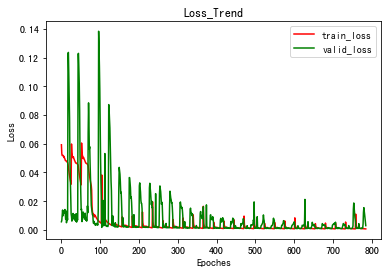

In [15]:
net = LSTM(1,2,256,2)

if train_on_gpu:
    net.cuda()
from time import time
start = time()
epochs = 30
train(net,epochs,train_loader,valid_loader,clip=5,print_every=100,lr=0.0001)
print('Training Time is',time()-start,'s')

Test loss: 0.019
Test Loss: 0.017469149082899094
actuale_angle_0:2.6513801934647825,prdict_angle_0:2.1981926354595136
actuale_angle_1:2.793040817392128,prdict_angle_1:2.4130895280846136
actuale_angle_2:2.8365866800878794,prdict_angle_2:-2.8000747188747006
actuale_angle_3:2.723297088450213,prdict_angle_3:-1.8929310793092344
actuale_angle_4:2.761172775787916,prdict_angle_4:-1.2979957103300337
actuale_angle_5:2.686957844105028,prdict_angle_5:-2.0838029272354284
actuale_angle_6:2.66373398961515,prdict_angle_6:1.8239223490118195
actuale_angle_7:2.6730776120761006,prdict_angle_7:1.1999266485563638
actuale_angle_8:2.6700625053967206,prdict_angle_8:1.408521752464891
actuale_angle_9:2.657600819194768,prdict_angle_9:1.4288441530715255
actuale_angle_10:2.6733031902110245,prdict_angle_10:1.563295031422988
actuale_angle_11:2.7309549191126465,prdict_angle_11:1.6048398896991138
actuale_angle_12:2.779817636093836,prdict_angle_12:-2.6664303888296326
actuale_angle_13:2.805601906593334,prdict_angle_13:-2

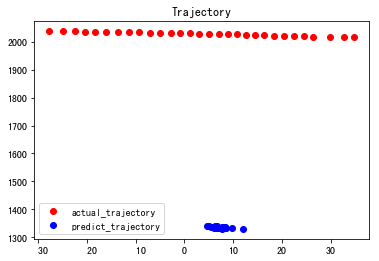

Test Loss: 0.020178288221359253
actuale_angle_0:-1.4735427138815567,prdict_angle_0:-1.5769062548169925
actuale_angle_1:-1.474492262589421,prdict_angle_1:-1.5444460913335194
actuale_angle_2:-1.4735427138815684,prdict_angle_2:-1.5960249843649397
actuale_angle_3:-1.4745937280161328,prdict_angle_3:-1.5117884231005538
actuale_angle_4:-1.4735446176985232,prdict_angle_4:-1.6154861739364719
actuale_angle_5:-1.4745937280161345,prdict_angle_5:-1.5300721015978063
actuale_angle_6:-1.473440153904065,prdict_angle_6:-1.5821205556776392
actuale_angle_7:-1.474593728016123,prdict_angle_7:-1.5487184472042856
actuale_angle_8:-1.477598935115414,prdict_angle_8:-1.6015825681535105
actuale_angle_9:-1.461741851698943,prdict_angle_9:0.8822100975473709
actuale_angle_10:-1.4280330998251214,prdict_angle_10:0.13818364217501777
actuale_angle_11:-1.3712644134323233,prdict_angle_11:-1.645703882745551
actuale_angle_12:-1.6109461651689831,prdict_angle_12:-1.9586633169087357
actuale_angle_13:-1.5906414366251513,prdict_an

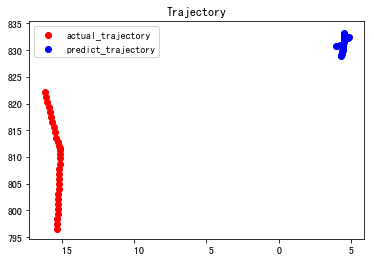

Test Loss: 0.025932191560665768
actuale_angle_0:0.0,prdict_angle_0:0.0
actuale_angle_1:0.0,prdict_angle_1:0.0
actuale_angle_2:0.0,prdict_angle_2:0.0
actuale_angle_3:0.0,prdict_angle_3:0.0
actuale_angle_4:0.0,prdict_angle_4:0.0
actuale_angle_5:0.0,prdict_angle_5:0.0
actuale_angle_6:0.0,prdict_angle_6:0.0
actuale_angle_7:0.0,prdict_angle_7:0.0
actuale_angle_8:0.0,prdict_angle_8:0.0
actuale_angle_9:0.0,prdict_angle_9:0.0
actuale_angle_10:0.0,prdict_angle_10:0.0
actuale_angle_11:0.0,prdict_angle_11:0.0
actuale_angle_12:0.0,prdict_angle_12:0.0
actuale_angle_13:0.0,prdict_angle_13:0.0
actuale_angle_14:0.0,prdict_angle_14:0.0
actuale_angle_15:0.0,prdict_angle_15:0.0
actuale_angle_16:0.0,prdict_angle_16:0.0
actuale_angle_17:0.0,prdict_angle_17:0.0
actuale_angle_18:0.0,prdict_angle_18:0.0
actuale_angle_19:0.0,prdict_angle_19:0.0
actuale_angle_20:0.0,prdict_angle_20:0.0
actuale_angle_21:0.0,prdict_angle_21:0.0
actuale_angle_22:0.0,prdict_angle_22:0.0
actuale_angle_23:0.0,prdict_angle_23:0.0
actu

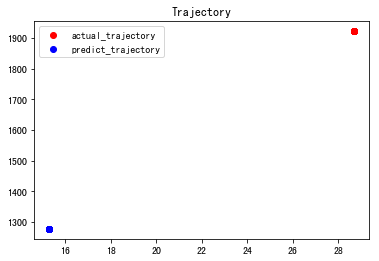

Test Loss: 0.02167463838122785
actuale_angle_0:2.283180892358394,prdict_angle_0:3.0975803650546956
actuale_angle_1:1.4160780064429115,prdict_angle_1:1.58217047569716
actuale_angle_2:1.0547048537908261,prdict_angle_2:-1.2789794846002192
actuale_angle_3:0.12266913341101164,prdict_angle_3:-0.8333742568405678
actuale_angle_4:-0.6369833094519128,prdict_angle_4:1.0262427830561567
actuale_angle_5:-1.496105941227737,prdict_angle_5:0.037628449341778156
actuale_angle_6:-1.769092658544223,prdict_angle_6:-0.9643360239465754
actuale_angle_7:-2.399044726705906,prdict_angle_7:-1.2253370053017596
actuale_angle_8:-2.6618394587735397,prdict_angle_8:-1.1255827902531155
actuale_angle_9:-2.7907909372569217,prdict_angle_9:1.1036758582275372
actuale_angle_10:-0.942474471493067,prdict_angle_10:2.5253742499773844
actuale_angle_11:-1.2338219410256792,prdict_angle_11:0.29949638329897976
actuale_angle_12:-1.8357090588474285,prdict_angle_12:-1.170959948876437
actuale_angle_13:-2.494128622828284,prdict_angle_13:-0.

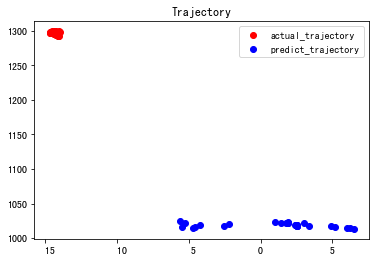

Test Loss: 0.025603846274316312
actuale_angle_0:2.7892316996276914,prdict_angle_0:1.9526886269591939
actuale_angle_1:2.7914958390934816,prdict_angle_1:1.6288947210511187
actuale_angle_2:2.8014663544916574,prdict_angle_2:2.1587922323568605
actuale_angle_3:2.782916378255573,prdict_angle_3:-2.7808326667335135
actuale_angle_4:2.7747308547362106,prdict_angle_4:-2.832606773923573
actuale_angle_5:2.7378441378999874,prdict_angle_5:2.891594652021259
actuale_angle_6:2.7400457772840126,prdict_angle_6:1.2213795224128134
actuale_angle_7:2.7572434802040875,prdict_angle_7:1.0578185907810922
actuale_angle_8:2.7931470869462554,prdict_angle_8:1.237821587579943
actuale_angle_9:2.840467251062483,prdict_angle_9:1.9190924633580988
actuale_angle_10:2.9116930443374116,prdict_angle_10:2.234690192601632
actuale_angle_11:2.96344078582645,prdict_angle_11:2.735467624195114
actuale_angle_12:2.980119477393514,prdict_angle_12:2.762658661129732
actuale_angle_13:2.9771453317986087,prdict_angle_13:2.0116343670945875
act

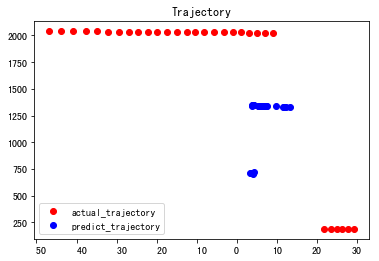

Test Loss: 0.02316525609542926
actuale_angle_0:-1.5698037791023465,prdict_angle_0:-1.6534656173467253
actuale_angle_1:-1.5701373569842365,prdict_angle_1:-1.6655500073841085
actuale_angle_2:-1.5707963267948966,prdict_angle_2:-1.6753186940079692
actuale_angle_3:-1.5686756507116975,prdict_angle_3:-1.6221818701148714
actuale_angle_4:-1.5739783113466899,prdict_angle_4:-1.5779208566133196
actuale_angle_5:-1.565930833515654,prdict_angle_5:0.9762859111294667
actuale_angle_6:-1.5487349289744565,prdict_angle_6:-1.52376576412478
actuale_angle_7:-1.5429866307230293,prdict_angle_7:-1.5885507275252195
actuale_angle_8:-1.5500868458422299,prdict_angle_8:-0.5740610126818196
actuale_angle_9:-1.5279735595170325,prdict_angle_9:1.3363396158937193
actuale_angle_10:-1.5744882360483585,prdict_angle_10:0.6247968304295126
actuale_angle_11:-1.6117361413974352,prdict_angle_11:-1.664526064249652
actuale_angle_12:-1.6454798958457015,prdict_angle_12:-1.4912425245053131
actuale_angle_13:-1.6041174541681023,prdict_ang

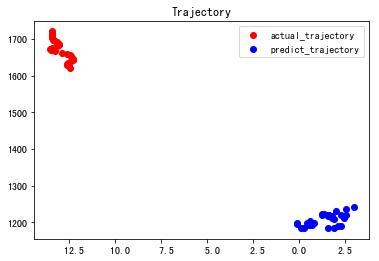

Test Loss: 0.026025516912341118
actuale_angle_0:1.611340411429508,prdict_angle_0:1.5954297249690579
actuale_angle_1:1.6111858130212369,prdict_angle_1:1.595020469772896
actuale_angle_2:1.6130465574600457,prdict_angle_2:1.5358787858125837
actuale_angle_3:1.6122432093307741,prdict_angle_3:1.5370060431690304
actuale_angle_4:1.6039205097821954,prdict_angle_4:1.8230111645809266
actuale_angle_5:1.593519792379635,prdict_angle_5:1.7344673490906148
actuale_angle_6:1.5846363306076292,prdict_angle_6:-1.6897374706826633
actuale_angle_7:1.5871754993038463,prdict_angle_7:1.5479802566261274
actuale_angle_8:1.5953975977277364,prdict_angle_8:1.5318601487153598
actuale_angle_9:1.573105736201589,prdict_angle_9:1.5318738737457243
actuale_angle_10:1.5377784583761207,prdict_angle_10:-1.656796445006496
actuale_angle_11:1.512880411841557,prdict_angle_11:-1.688252269808551
actuale_angle_12:1.4744217765031298,prdict_angle_12:-1.7742895431558756
actuale_angle_13:1.4888590559936947,prdict_angle_13:1.53223821344439

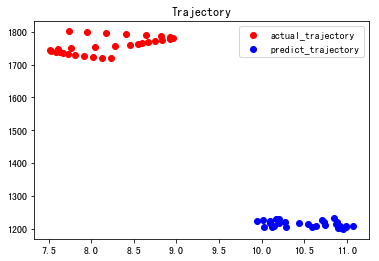

Test Loss: 0.027584866853430867
actuale_angle_0:2.1705581390765794,prdict_angle_0:1.523296201108918
actuale_angle_1:2.0970242361945792,prdict_angle_1:1.4424684995400792
actuale_angle_2:2.142563820580061,prdict_angle_2:-1.6906258799012732
actuale_angle_3:2.137939826439909,prdict_angle_3:-1.7180331778369904
actuale_angle_4:2.1355314300327874,prdict_angle_4:1.7459347480733864
actuale_angle_5:2.138395477173884,prdict_angle_5:1.5187270717045285
actuale_angle_6:2.140637006275519,prdict_angle_6:1.5488088190217622
actuale_angle_7:2.1410678671596113,prdict_angle_7:1.5478432670371158
actuale_angle_8:2.1433421921795524,prdict_angle_8:1.549749186601456
actuale_angle_9:2.1443794844054747,prdict_angle_9:1.55186412244121
actuale_angle_10:2.1451896244935016,prdict_angle_10:1.5517712862146056
actuale_angle_11:2.146604066784933,prdict_angle_11:1.5481670139214567
actuale_angle_12:2.1490756153209367,prdict_angle_12:1.5496023159812145
actuale_angle_13:2.132748016427827,prdict_angle_13:1.7187405306171508
ac

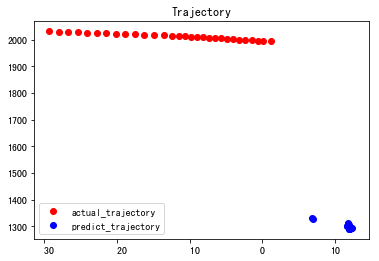

Test Loss: 0.025303425784740183
actuale_angle_0:-1.6368158375892892,prdict_angle_0:-1.7172679035639973
actuale_angle_1:-1.6347584696825463,prdict_angle_1:-1.8018779078770044
actuale_angle_2:-1.6357203609510538,prdict_angle_2:-1.7354797446611785
actuale_angle_3:-1.6357203609510538,prdict_angle_3:-1.7817439347005946
actuale_angle_4:-1.6355875138074565,prdict_angle_4:-1.7370480710787273
actuale_angle_5:-1.6355205980307994,prdict_angle_5:-1.7949369378505509
actuale_angle_6:-1.6370888947090232,prdict_angle_6:-1.872503195967573
actuale_angle_7:-1.6342032996363598,prdict_angle_7:-2.5287364023650594
actuale_angle_8:-1.6316569629570015,prdict_angle_8:-1.9519713729956536
actuale_angle_9:-1.6296175664481296,prdict_angle_9:-1.7732220501182714
actuale_angle_10:-1.627359343321943,prdict_angle_10:-1.737533121414957
actuale_angle_11:-1.633510421624696,prdict_angle_11:1.5059569785792895
actuale_angle_12:-1.6485803443539273,prdict_angle_12:1.5598644291336208
actuale_angle_13:-1.7327321750714015,prdict_a

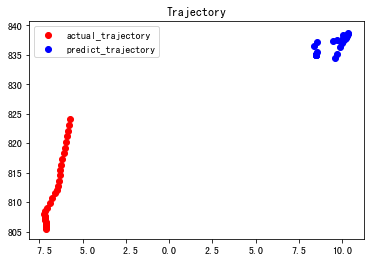

Test Loss: 0.02479358846321702
actuale_angle_0:-1.5519168492744821,prdict_angle_0:-1.6488237681524465
actuale_angle_1:1.736418077308526,prdict_angle_1:3.096655952250571
actuale_angle_2:1.5707963267948966,prdict_angle_2:-0.018114331430190114
actuale_angle_3:1.5707963267948966,prdict_angle_3:1.5616380974463
actuale_angle_4:-1.5707963267948966,prdict_angle_4:-1.6702389211823059
actuale_angle_5:0.0,prdict_angle_5:1.5822476710202602
actuale_angle_6:0.0,prdict_angle_6:0.0
actuale_angle_7:0.0,prdict_angle_7:0.0
actuale_angle_8:0.0,prdict_angle_8:0.0
actuale_angle_9:0.0,prdict_angle_9:0.0
actuale_angle_10:0.0,prdict_angle_10:0.0
actuale_angle_11:0.0,prdict_angle_11:0.0
actuale_angle_12:0.0,prdict_angle_12:0.0
actuale_angle_13:0.0,prdict_angle_13:0.0
actuale_angle_14:0.0,prdict_angle_14:0.0
actuale_angle_15:0.0,prdict_angle_15:0.0
actuale_angle_16:0.0,prdict_angle_16:0.0
actuale_angle_17:0.0,prdict_angle_17:0.0
actuale_angle_18:0.0,prdict_angle_18:0.0
actuale_angle_19:0.0,prdict_angle_19:0.0
ac

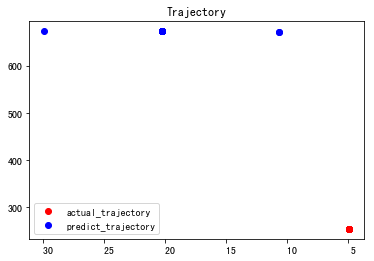

Test Loss: 0.02394907328892838
actuale_angle_0:0.0,prdict_angle_0:0.0
actuale_angle_1:0.0,prdict_angle_1:0.0
actuale_angle_2:0.0,prdict_angle_2:0.0
actuale_angle_3:-1.5707963267948966,prdict_angle_3:0.0
actuale_angle_4:1.5707963267948966,prdict_angle_4:1.5817873533237723
actuale_angle_5:1.5707963267948966,prdict_angle_5:1.4647879062710976
actuale_angle_6:2.1366834004149773,prdict_angle_6:3.1154544200443572
actuale_angle_7:-1.5199984623510054,prdict_angle_7:-0.045866854207604245
actuale_angle_8:-1.4025649315671744,prdict_angle_8:2.4415989484712393
actuale_angle_9:-1.3511683908018743,prdict_angle_9:1.962964607107686
actuale_angle_10:-1.3510394646452393,prdict_angle_10:1.303962847068233
actuale_angle_11:-1.3650212776686614,prdict_angle_11:1.2187346374278663
actuale_angle_12:-1.3765030887798326,prdict_angle_12:1.0271793198548291
actuale_angle_13:-1.3741138693492756,prdict_angle_13:-0.6190038792578559
actuale_angle_14:-1.3701845340093717,prdict_angle_14:-1.6436313836468737
actuale_angle_15:

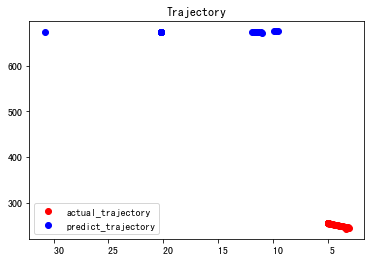

Test Loss: 0.022881159326061606
actuale_angle_0:-1.5565770782719268,prdict_angle_0:2.1460670301357228
actuale_angle_1:-1.593211646690128,prdict_angle_1:-1.4411757220942212
actuale_angle_2:-1.6229299727040616,prdict_angle_2:-1.45351771953773
actuale_angle_3:-1.641737244492666,prdict_angle_3:-1.7653622065719727
actuale_angle_4:-1.6370386467848974,prdict_angle_4:-1.7870188771289974
actuale_angle_5:-1.6432607619815154,prdict_angle_5:-1.5664767984467474
actuale_angle_6:-1.6871553547669094,prdict_angle_6:-1.201395399679512
actuale_angle_7:-1.6977511753365608,prdict_angle_7:-1.4717694241812929
actuale_angle_8:-1.6405967462187567,prdict_angle_8:-1.6736780973810592
actuale_angle_9:-1.5879372429213694,prdict_angle_9:-1.721115982393643
actuale_angle_10:-1.5548253120040951,prdict_angle_10:-1.6493863294153446
actuale_angle_11:-1.5733656374333587,prdict_angle_11:-2.221581927029793
actuale_angle_12:-1.6030520461572586,prdict_angle_12:-1.7415988181139361
actuale_angle_13:-1.6331618236763759,prdict_ang

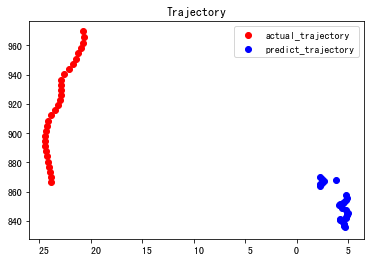

Test Loss: 0.02268059043070445
actuale_angle_0:-0.45734657881070534,prdict_angle_0:0.7185707632159083
actuale_angle_1:-0.6093411274288606,prdict_angle_1:0.8106508570107204
actuale_angle_2:-0.7765259750633857,prdict_angle_2:0.7442002617419461
actuale_angle_3:-0.9116393563183095,prdict_angle_3:0.74707429792409
actuale_angle_4:-0.9695178190953229,prdict_angle_4:1.426381803528999
actuale_angle_5:-0.9798135027783823,prdict_angle_5:-1.008338990045425
actuale_angle_6:-0.9902142446462232,prdict_angle_6:1.0068162662371847
actuale_angle_7:-1.0080374326316894,prdict_angle_7:1.0152793614251443
actuale_angle_8:-1.0259523329737552,prdict_angle_8:0.9758328076524403
actuale_angle_9:-1.041467766806604,prdict_angle_9:0.9531278310201939
actuale_angle_10:-1.056508806697963,prdict_angle_10:0.931809510217846
actuale_angle_11:-1.0664089414969729,prdict_angle_11:0.7908169105222397
actuale_angle_12:-1.070343722477817,prdict_angle_12:1.8743178369713316
actuale_angle_13:-1.0851158793730016,prdict_angle_13:1.5984

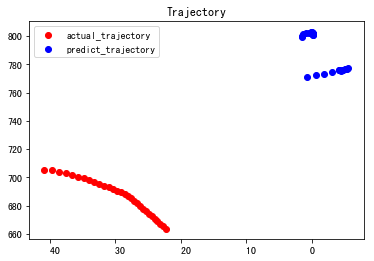

Test Loss: 0.022650868432330235
actuale_angle_0:0.0,prdict_angle_0:0.0
actuale_angle_1:0.0,prdict_angle_1:0.0
actuale_angle_2:0.0,prdict_angle_2:0.0
actuale_angle_3:0.0,prdict_angle_3:0.0
actuale_angle_4:0.0,prdict_angle_4:0.0
actuale_angle_5:0.0,prdict_angle_5:0.0
actuale_angle_6:0.0,prdict_angle_6:0.0
actuale_angle_7:0.0,prdict_angle_7:0.0
actuale_angle_8:0.0,prdict_angle_8:0.0
actuale_angle_9:0.0,prdict_angle_9:0.0
actuale_angle_10:0.0,prdict_angle_10:0.0
actuale_angle_11:0.0,prdict_angle_11:0.0
actuale_angle_12:0.0,prdict_angle_12:0.0
actuale_angle_13:0.0,prdict_angle_13:0.0
actuale_angle_14:0.0,prdict_angle_14:0.0
actuale_angle_15:0.0,prdict_angle_15:0.0
actuale_angle_16:0.0,prdict_angle_16:0.0
actuale_angle_17:0.0,prdict_angle_17:0.0
actuale_angle_18:0.0,prdict_angle_18:0.0
actuale_angle_19:0.0,prdict_angle_19:0.0
actuale_angle_20:0.0,prdict_angle_20:0.0
actuale_angle_21:0.0,prdict_angle_21:0.0
actuale_angle_22:0.0,prdict_angle_22:0.0
actuale_angle_23:0.0,prdict_angle_23:0.0
actu

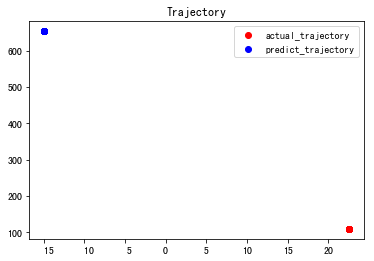

Test Loss: 0.021583380519102018
actuale_angle_0:1.4503788239078839,prdict_angle_0:1.7320381330570884
actuale_angle_1:1.4453782224327816,prdict_angle_1:1.5054467145754757
actuale_angle_2:1.4609464896049904,prdict_angle_2:1.5209197678983732
actuale_angle_3:1.4588563114795565,prdict_angle_3:0.6901544306996648
actuale_angle_4:1.4505496339357553,prdict_angle_4:1.5418921939112973
actuale_angle_5:1.4456203146038185,prdict_angle_5:1.3823570018408253
actuale_angle_6:1.4753811209856782,prdict_angle_6:1.4500861238519789
actuale_angle_7:1.4984547571805713,prdict_angle_7:1.6636905544602378
actuale_angle_8:1.5212914379210967,prdict_angle_8:1.6178318966466156
actuale_angle_9:1.5563650761601733,prdict_angle_9:1.6220305119700202
actuale_angle_10:1.553023323117354,prdict_angle_10:1.502821822876661
actuale_angle_11:1.5366960476142062,prdict_angle_11:1.5428195343243216
actuale_angle_12:1.5285818176485821,prdict_angle_12:1.6319454991728024
actuale_angle_13:1.5294176180668568,prdict_angle_13:1.5108576128013

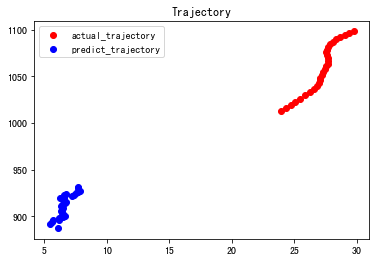

Test Loss: 0.022561405057786033
actuale_angle_0:1.4650597392728886,prdict_angle_0:1.5652636384482401
actuale_angle_1:1.4902126144963763,prdict_angle_1:1.5693314598919492
actuale_angle_2:1.5086985159531887,prdict_angle_2:1.4353249252922302
actuale_angle_3:1.521665132319668,prdict_angle_3:1.5344952923662227
actuale_angle_4:1.5088380656496072,prdict_angle_4:1.5602907654723266
actuale_angle_5:1.4911878878388696,prdict_angle_5:-2.524195497871033
actuale_angle_6:1.4934791792824487,prdict_angle_6:-1.8983722491461719
actuale_angle_7:1.5202260460082746,prdict_angle_7:1.7639680409803382
actuale_angle_8:1.5359885127751882,prdict_angle_8:1.5779522257154308
actuale_angle_9:1.5556765005022972,prdict_angle_9:1.4554009955825316
actuale_angle_10:1.5593094784487376,prdict_angle_10:1.486998822009226
actuale_angle_11:1.5653183424416233,prdict_angle_11:1.5852554078972851
actuale_angle_12:1.5800939144162138,prdict_angle_12:-2.498685733263435
actuale_angle_13:1.5888995189030268,prdict_angle_13:-1.51007904905

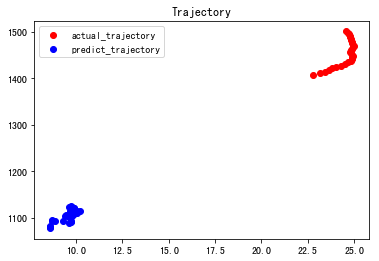

Test Loss: 0.02180475284181097
actuale_angle_0:1.6204469476058943,prdict_angle_0:-2.993648348989196
actuale_angle_1:1.6299732346831983,prdict_angle_1:1.1248518478660317
actuale_angle_2:1.631107212342765,prdict_angle_2:1.266160044091438
actuale_angle_3:1.6327472061888342,prdict_angle_3:1.3583557019088808
actuale_angle_4:1.6338064708946016,prdict_angle_4:1.430785567026396
actuale_angle_5:1.630373403621074,prdict_angle_5:1.539053502026428
actuale_angle_6:1.6305123021032606,prdict_angle_6:1.6936867584930198
actuale_angle_7:1.6308254562359015,prdict_angle_7:1.614851034427301
actuale_angle_8:1.6313297176383992,prdict_angle_8:1.0752345253114404
actuale_angle_9:1.6306064856798541,prdict_angle_9:1.4413661272495226
actuale_angle_10:1.6306104997224968,prdict_angle_10:1.4099150044543214
actuale_angle_11:1.6306077886085308,prdict_angle_11:1.3797318338257374
actuale_angle_12:1.6306539109559806,prdict_angle_12:1.4409588742873778
actuale_angle_13:1.6306511959100969,prdict_angle_13:1.379777449693549
ac

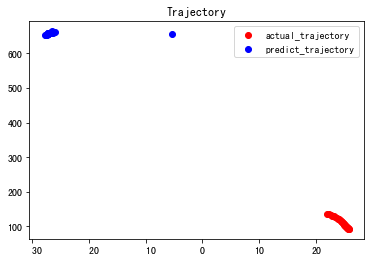

Test Loss: 0.02155212998493678
actuale_angle_0:0.0,prdict_angle_0:0.0
actuale_angle_1:0.0,prdict_angle_1:0.0
actuale_angle_2:0.0,prdict_angle_2:0.0
actuale_angle_3:0.0,prdict_angle_3:0.0
actuale_angle_4:0.0,prdict_angle_4:0.0
actuale_angle_5:0.0,prdict_angle_5:0.0
actuale_angle_6:0.0,prdict_angle_6:0.0
actuale_angle_7:0.0,prdict_angle_7:0.0
actuale_angle_8:0.0,prdict_angle_8:0.0
actuale_angle_9:0.0,prdict_angle_9:0.0
actuale_angle_10:0.0,prdict_angle_10:0.0
actuale_angle_11:0.0,prdict_angle_11:-1.3297804408787917
actuale_angle_12:0.0,prdict_angle_12:1.8118122127110017
actuale_angle_13:0.0,prdict_angle_13:0.0
actuale_angle_14:0.0,prdict_angle_14:0.0
actuale_angle_15:0.0,prdict_angle_15:0.0
actuale_angle_16:0.0,prdict_angle_16:-1.3297804408787917
actuale_angle_17:0.0,prdict_angle_17:0.0
actuale_angle_18:0.0,prdict_angle_18:0.0
actuale_angle_19:0.0,prdict_angle_19:0.0
actuale_angle_20:0.0,prdict_angle_20:0.0
actuale_angle_21:0.0,prdict_angle_21:0.0
actuale_angle_22:0.0,prdict_angle_22:0.0

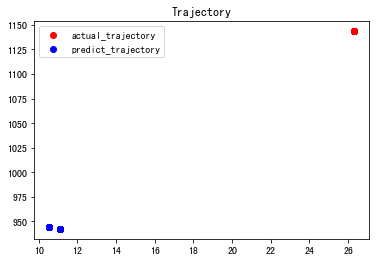

Test Loss: 0.021884660015961056
actuale_angle_0:0.0,prdict_angle_0:0.0
actuale_angle_1:0.0,prdict_angle_1:0.0
actuale_angle_2:0.0,prdict_angle_2:0.0
actuale_angle_3:0.0,prdict_angle_3:0.0
actuale_angle_4:0.0,prdict_angle_4:0.0
actuale_angle_5:0.0,prdict_angle_5:0.0
actuale_angle_6:0.0,prdict_angle_6:0.0
actuale_angle_7:0.0,prdict_angle_7:0.0
actuale_angle_8:0.0,prdict_angle_8:0.0
actuale_angle_9:0.0,prdict_angle_9:0.0
actuale_angle_10:0.0,prdict_angle_10:0.0
actuale_angle_11:0.0,prdict_angle_11:0.0
actuale_angle_12:0.0,prdict_angle_12:0.0
actuale_angle_13:0.0,prdict_angle_13:0.0
actuale_angle_14:0.0,prdict_angle_14:0.0
actuale_angle_15:0.0,prdict_angle_15:0.0
actuale_angle_16:0.0,prdict_angle_16:0.0
actuale_angle_17:0.0,prdict_angle_17:0.0
actuale_angle_18:0.0,prdict_angle_18:0.0
actuale_angle_19:0.0,prdict_angle_19:0.0
actuale_angle_20:0.0,prdict_angle_20:0.0
actuale_angle_21:0.0,prdict_angle_21:0.0
actuale_angle_22:0.0,prdict_angle_22:0.0
actuale_angle_23:0.0,prdict_angle_23:0.0
actu

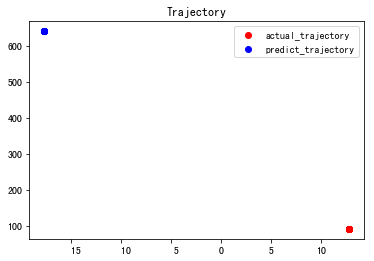

Test Loss: 0.02194956357125193
actuale_angle_0:1.5083613687005029,prdict_angle_0:1.158170174792432
actuale_angle_1:1.4644814567585969,prdict_angle_1:1.2155442808249441
actuale_angle_2:1.4223244174727026,prdict_angle_2:1.175269865999779
actuale_angle_3:1.3796822917823266,prdict_angle_3:1.2932915068240078
actuale_angle_4:1.4179564340197208,prdict_angle_4:1.4737720286220042
actuale_angle_5:1.472445035605721,prdict_angle_5:1.444680293077362
actuale_angle_6:1.527156137862572,prdict_angle_6:1.4327587876062795
actuale_angle_7:1.574978399795966,prdict_angle_7:-1.7254547614053124
actuale_angle_8:1.6315263391529478,prdict_angle_8:0.9945438251788504
actuale_angle_9:1.6018486932391522,prdict_angle_9:1.692671997287035
actuale_angle_10:1.5667176155320512,prdict_angle_10:-1.2955423707495723
actuale_angle_11:1.5183717098999518,prdict_angle_11:-0.3001005581629368
actuale_angle_12:1.4662834606493584,prdict_angle_12:1.0082220062954863
actuale_angle_13:1.424431225291176,prdict_angle_13:1.08163311350638
ac

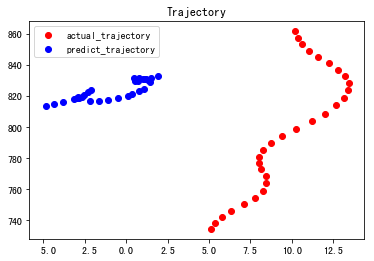

In [14]:
net_test = LSTM(1,2,256,2)
if train_on_gpu:
    net_test.cuda()
    
net_test.load_state_dict(torch.load('model/lstm_trajectory_prediction_old.pt'))
test(net_test,train_loader)
actual_angles,predict_angles = predict(net_test,train_loader)

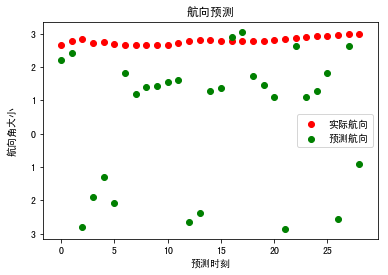

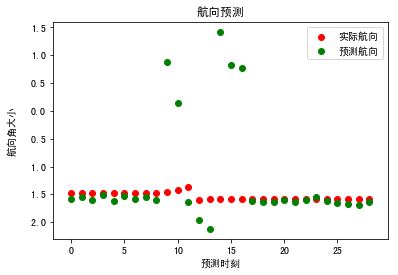

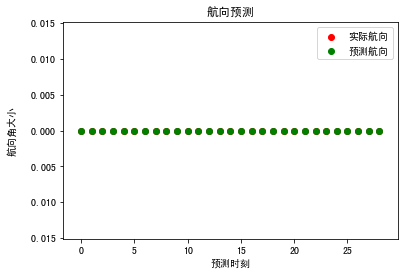

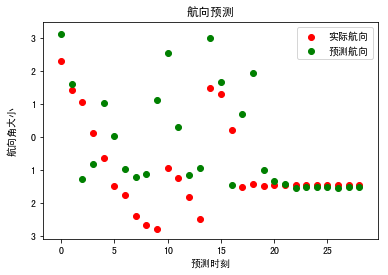

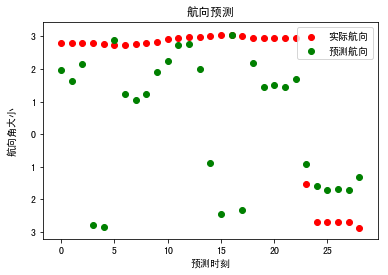

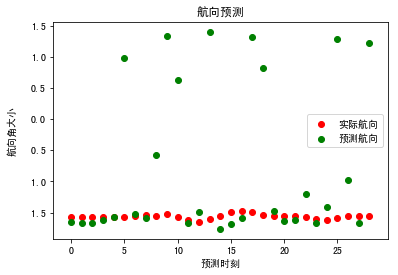

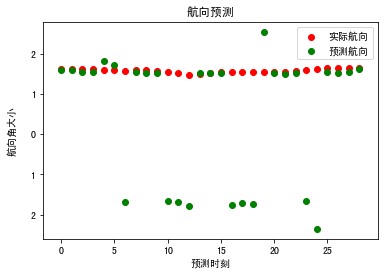

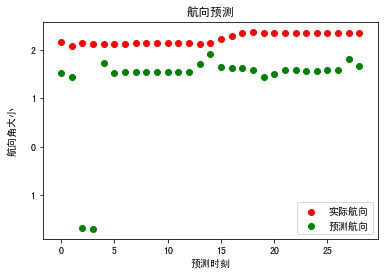

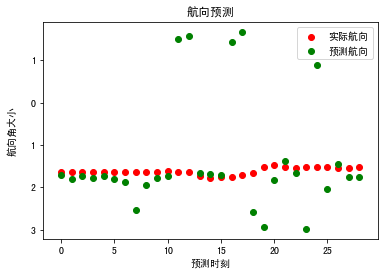

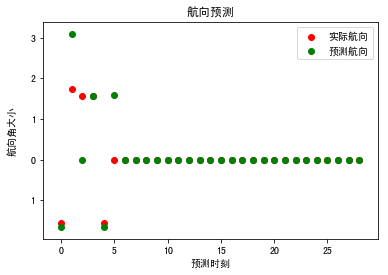

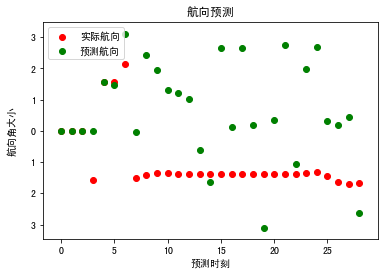

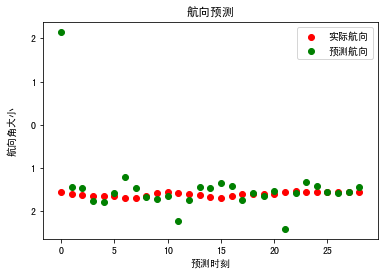

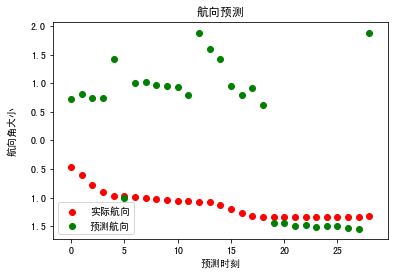

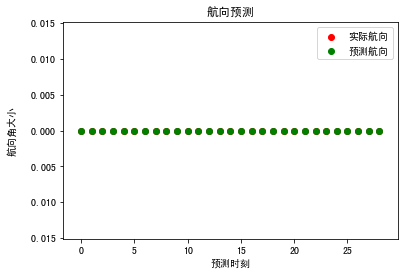

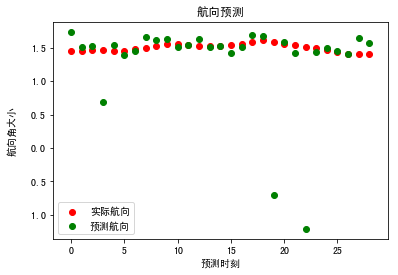

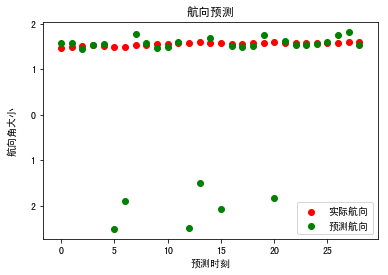

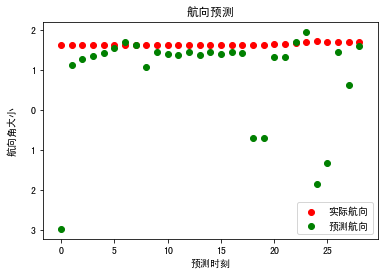

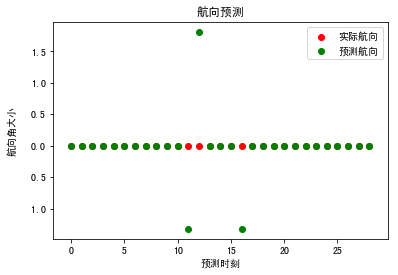

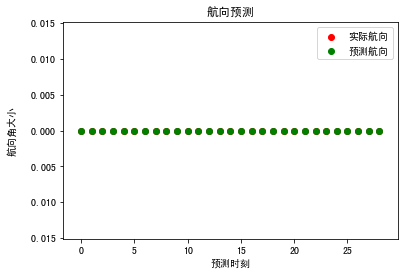

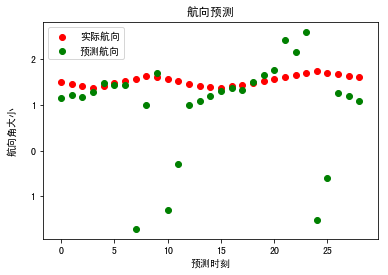

In [12]:
i_= 0
for i in range(0,len(actual_angles),29):
    plt.scatter([range(len(actual_angles[i:i+29]))],actual_angles[i:i+29],color='r',label='实际航向')
    plt.scatter([range(len(predict_angles[i:i+29]))],predict_angles[i:i+29],color='g',label='预测航向')
    #plt.title('Loss_Trend')
    #plt.xlabel('Epoches')
    #plt.ylabel('Loss')
    plt.title('航向预测')
    plt.xlabel('预测时刻')
    plt.ylabel('航向角大小')
    plt.legend()
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.savefig('trajectory_image/航向_old/svg/航向_old_{}.svg'.format(i_),dpi=300)
    plt.savefig('trajectory_image/航向_old/png/航向_old_{}.png'.format(i_),dpi=300)
    i_ += 1
    plt.show()